In [43]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.python.keras import layers, optimizers
from tensorflow.keras.callbacks import Callback, EarlyStopping
#import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt


In [44]:
input_size = (224, 224)

In [45]:
datagen = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True,
                             vertical_flip=True,
                             rotation_range=30,
                             validation_split=0.2
                             )
# prepare an iterators for each dataset
train_it = datagen.flow_from_directory( 'dataset', 
                                       class_mode='categorical',
                                       classes=['dew', 'fogsmog','frost','glaze','hail','lightning','rain','rainbow','rime','sandstorm','snow'],
                                       target_size=(224, 224),
                                       batch_size=128,
                                       subset='training',
                                       seed=7)
# prepare an iterators for each dataset
val_it = datagen.flow_from_directory( 'dataset', 
                                       class_mode='categorical',
                                       classes=['dew', 'fogsmog','frost','glaze','hail','lightning','rain','rainbow','rime','sandstorm','snow'],
                                       target_size=(224, 224),
                                       batch_size=128,
                                       subset='validation',
                                       seed=7)

Found 5493 images belonging to 11 classes.
Found 1369 images belonging to 11 classes.


In [46]:
# confirm the iterator works
batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(128, 224, 224, 3), min=0.000, max=1.000


In [47]:
"""# Create Simple CNN model"""

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import Sequential

model = Sequential()
model.add(Conv2D(32, (5,5),padding='same',activation='relu',input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(4,4)))
# REPEAT CONV AND POOLING layer 3 TIMES
model.add(Conv2D(64, (5,5),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
#model.add(Conv2D(128, (5,5),padding='valid',activation='relu'))
# model.add(Conv2D(256, (5,5),padding='valid',activation='relu'))
# model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(11,activation='softmax'))

In [48]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,decay_steps=10000,decay_rate=0.9)

In [49]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
  loss=CategoricalCrossentropy(),
  metrics=['accuracy'])


stop_early= [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='min')]



In [50]:
history = model.fit( 
  train_it,
  validation_data=val_it,
  epochs=30,
  callbacks=stop_early)

Epoch 1/30
43/43 [==============================] - 186s 4s/step - loss: 2.3489 - accuracy: 0.1617 - val_loss: 2.2868 - val_accuracy: 0.1965
Epoch 2/30
43/43 [==============================] - 175s 4s/step - loss: 2.2137 - accuracy: 0.2237 - val_loss: 2.1520 - val_accuracy: 0.2272
Epoch 3/30
43/43 [==============================] - 183s 4s/step - loss: 2.0711 - accuracy: 0.2966 - val_loss: 1.9805 - val_accuracy: 0.3163
Epoch 4/30
43/43 [==============================] - 175s 4s/step - loss: 1.9638 - accuracy: 0.3228 - val_loss: 1.9685 - val_accuracy: 0.3178
Epoch 5/30
43/43 [==============================] - 174s 4s/step - loss: 1.8616 - accuracy: 0.3623 - val_loss: 2.2589 - val_accuracy: 0.2272
Epoch 6/30
43/43 [==============================] - 178s 4s/step - loss: 1.7936 - accuracy: 0.3932 - val_loss: 1.7180 - val_accuracy: 0.4405
Epoch 7/30
43/43 [==============================] - 174s 4s/step - loss: 1.6921 - accuracy: 0.4358 - val_loss: 1.7389 - val_accuracy: 0.3996
Epoch 8/30
43

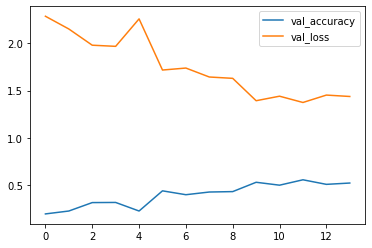

In [51]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.legend(['val_accuracy','val_loss'])

In [52]:
acc=history.history['val_accuracy']
print(f'Accuracy: {np.round(acc[-1]*100)} %')

Accuracy: 52.0 %


In [53]:
loss=history.history['val_loss']
print(f'Loss: {loss[-1]}')

Loss: 1.438339114189148


In [54]:
model.save("model_CNN_1.h5")

# Fine Tuning

In [55]:
#https://www.kaggle.com/code/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy/notebook
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (224, 224, 3)
num_classes = 11

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.15))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.10))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.10))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 64)      36928     
                                                      

In [56]:
# Compile the model
model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [59]:
# Set a learning rate annealer
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [60]:
history = model.fit( 
  train_it,
  validation_data=val_it,
  epochs=30,
  callbacks=[learning_rate_reduction])

Epoch 1/30
43/43 [==============================] - 670s 16s/step - loss: 1.3202 - accuracy: 0.5522 - val_loss: 1.2488 - val_accuracy: 0.5814 - lr: 0.0010
Epoch 2/30
43/43 [==============================] - 676s 16s/step - loss: 1.3094 - accuracy: 0.5458 - val_loss: 1.1800 - val_accuracy: 0.5953 - lr: 0.0010
Epoch 3/30
43/43 [==============================] - 672s 16s/step - loss: 1.2823 - accuracy: 0.5587 - val_loss: 1.1525 - val_accuracy: 0.6326 - lr: 0.0010
Epoch 4/30
43/43 [==============================] - 680s 16s/step - loss: 1.2500 - accuracy: 0.5709 - val_loss: 1.1453 - val_accuracy: 0.6165 - lr: 0.0010
Epoch 5/30
43/43 [==============================] - 653s 15s/step - loss: 1.2375 - accuracy: 0.5762 - val_loss: 1.1202 - val_accuracy: 0.6275 - lr: 0.0010
Epoch 6/30
43/43 [==============================] - 691s 16s/step - loss: 1.2263 - accuracy: 0.5775 - val_loss: 1.0930 - val_accuracy: 0.6413 - lr: 0.0010
Epoch 7/30
43/43 [==============================] - 680s 16s/step - lo

In [67]:
results = model.evaluate(val_it, verbose=1)
    
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))


11/11 [==============================] - 28s 2s/step - loss: 0.9424 - accuracy: 0.6764
    Test Loss: 0.94236
Test Accuracy: 67.64%


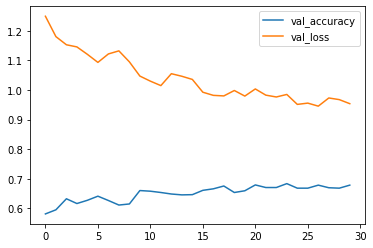

In [63]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.legend(['val_accuracy','val_loss'])

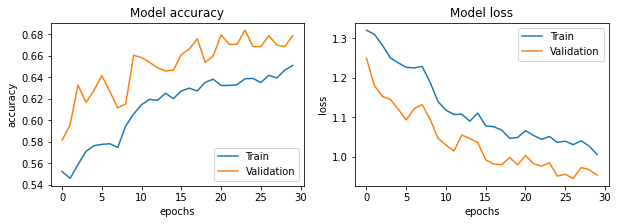

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
for i, parameter in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[parameter])
        ax[i].plot(history.history['val_' + parameter])
        ax[i].set_title(f'Model {parameter}')
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(parameter)
        ax[i].legend(['Train', 'Validation'])

In [68]:
model.save("model_CNN_2.h5")

In [70]:
acc=history.history['val_accuracy']
print(f'Accuracy: {np.round(acc[-1]*100)} %')
loss=history.history['val_loss']
print(f'Loss: {loss[-1]}')

Accuracy: 68.0 %
Loss: 0.9536527991294861


https://www.kaggle.com/code/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy/notebook